In [2]:
import torch
from torch import nn, optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

In [2]:
train_transform = transforms.Compose([
    transforms.RandomRotation(degrees=90),
    transforms.ColorJitter(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomAffine(10, translate=(0.1, 0.2)),
    transforms.Resize(size=[224, 224]),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [3]:
transform = transforms.Compose([
    transforms.Resize(size=[224, 224]),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [4]:
train_dataset = datasets.ImageFolder(root = "images/train", transform = train_transform)
valid_dataset = datasets.ImageFolder(root = "images/valid", transform = transform)
test_dataset = datasets.ImageFolder(root = "images/test", transform = transform)

In [5]:
train_loader = DataLoader(train_dataset, shuffle=True, batch_size = 32, drop_last = True)
valid_loader = DataLoader(valid_dataset, shuffle=True, batch_size = 32, drop_last = True)
test_loader = DataLoader(test_dataset, shuffle=True, batch_size = 32, drop_last = True)

In [6]:
model = models.densenet161(pretrained = True)
print(model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [7]:
for param in model.parameters():
    param.requires_grad = False

In [8]:
model.classifier = nn.Sequential(nn.Linear(2208, 256),
                                 nn.ReLU(),
                                 nn.Linear(256, 3),
                                 nn.LogSoftmax(dim=1))

In [9]:
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_criterion = nn.NLLLoss()

In [1]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

NameError: name 'torch' is not defined

In [11]:
epochs = 20

train_loss_list = []
valid_loss_list = []
train_accuracy_list = []
valid_accuracy_list = []

for e in range(epochs):
    running_loss = 0
    train_accuracy = 0
    
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        predictions = model.forward(inputs)
        loss = loss_criterion(predictions, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        ps = torch.exp(predictions)
        equality = (labels.data == ps.max(dim=1)[1])
        train_accuracy += equality.type(torch.FloatTensor).mean()
        
    
    train_loss = running_loss / len(train_loader.dataset)
    train_loss_list.append(train_loss)
    train_accuracy_list.append(train_accuracy/len(train_loader))
    
    running_loss = 0
    valid_accuracy = 0
    
    model.eval()
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            predictions = model.forward(inputs)
            loss = loss_criterion(predictions, labels)
            running_loss += loss.item()
            
            ps = torch.exp(predictions)
            equality = (labels.data == ps.max(dim=1)[1])
            valid_accuracy += equality.type(torch.FloatTensor).mean()
    
    valid_loss = running_loss / len(valid_loader.dataset)
    valid_loss_list.append(valid_loss)
    valid_accuracy_list.append(valid_accuracy/len(valid_loader))

    print(f"Epoch {e+1}/{epochs}.. "
            f"Train loss: {train_loss:.3f}.. "
            f"Validation loss: {valid_loss:.3f}.. "
            f"Train accuracy: {train_accuracy/len(train_loader):.3f}.. "
            f"Validation accuracy: {valid_accuracy/len(valid_loader):.3f}")

Epoch 1/20.. Train loss: 0.086.. Validation loss: 0.017.. Train accuracy: 0.522.. Validation accuracy: 0.594
Epoch 2/20.. Train loss: 0.019.. Validation loss: 0.013.. Train accuracy: 0.666.. Validation accuracy: 0.656
Epoch 3/20.. Train loss: 0.016.. Validation loss: 0.013.. Train accuracy: 0.734.. Validation accuracy: 0.641
Epoch 4/20.. Train loss: 0.015.. Validation loss: 0.010.. Train accuracy: 0.688.. Validation accuracy: 0.844
Epoch 5/20.. Train loss: 0.013.. Validation loss: 0.009.. Train accuracy: 0.775.. Validation accuracy: 0.859
Epoch 6/20.. Train loss: 0.010.. Validation loss: 0.011.. Train accuracy: 0.856.. Validation accuracy: 0.812
Epoch 7/20.. Train loss: 0.011.. Validation loss: 0.009.. Train accuracy: 0.828.. Validation accuracy: 0.859
Epoch 8/20.. Train loss: 0.010.. Validation loss: 0.008.. Train accuracy: 0.863.. Validation accuracy: 0.875
Epoch 9/20.. Train loss: 0.009.. Validation loss: 0.006.. Train accuracy: 0.869.. Validation accuracy: 0.906
Epoch 10/20.. Train

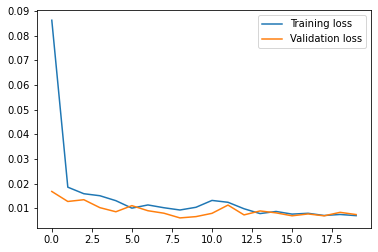

In [12]:
plt.plot(train_loss_list, label='Training loss')
plt.plot(valid_loss_list, label='Validation loss')
plt.legend()

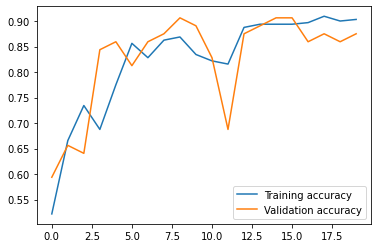

In [13]:
plt.plot(train_accuracy_list, label='Training accuracy')
plt.plot(valid_accuracy_list, label='Validation accuracy')
plt.legend()

In [14]:
test_accuracy = 0

model.eval()
for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)

    predictions = model.forward(images)
    ps = torch.exp(predictions)
    equality = (labels.data == ps.max(dim=1)[1])
    test_accuracy += equality.type(torch.FloatTensor).mean()
    
print(f"Holdout accuracy: {test_accuracy/len(test_loader):.3f}")

Holdout accuracy: 0.906
